# Important note!

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [32]:
YOUR_ID = "aroy74" # Please enter your GT login, e.g., "rvuduc3" or "gtg911x"
COLLABORATORS = [] # list of strings of your collaborators' IDs

In [33]:
import re

RE_CHECK_ID = re.compile (r'''[a-zA-Z]+\d+|[gG][tT][gG]\d+[a-zA-Z]''')
assert RE_CHECK_ID.match (YOUR_ID) is not None

collab_check = [RE_CHECK_ID.match (i) is not None for i in COLLABORATORS]
assert all (collab_check)

del collab_check
del RE_CHECK_ID
del re

**Jupyter / IPython version check.** The following code cell verifies that you are using the correct version of Jupyter/IPython.

In [34]:
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

# Logistic regression

Beyond regression, another important data analysis task is _classification_, in which you are given a set of labeled data points and you wish to learn a model of the labels. One technique you can apply is _logistic regression_, the topic of today's lab.

> Although it's called "regression" it is really a model for classification.

This notebook is about _binary classification_, where each data point belongs to one of $c=2$ possible classes. By convention, we will denote these _class labels_ by "0" and "1." However, the ideas can be generalized to the multiclass ($c > 2$) case.

Some of today's code snippets use Seaborn, so you may need to refer back the [optional notebook from `lab_bokeh`](http://nbviewer.ipython.org/github/rvuduc/cse6040fa16labs/blob/master/lab_bokeh/seaborn.ipynb) that explains how to use it.

This lab builds on the iterative numerical optimization idea from [Lab 9](http://nbviewer.ipython.org/github/rvuduc/cse6040fa16labs/blob/master/lab9/part3.ipynb), which is known as _gradient ascent_ or _gradient descent_ (also, _steepest ascent/descent_), depending on whether one is maximizing or minimizing some quantity.

## Preliminaries

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Math

%matplotlib inline

**A note about slicing columns from a Numpy matrix.** If you want to extract a column `i` from a Numpy matrix `A` _and_ keep it as a column vector, you need to use the slicing notation, `A[:, i:i+1]`. Not doing so can lead to subtle bugs. To see why, compare the following slices.

In [36]:
A = np.array ([[1, 2, 3],
               [4, 5, 6],
               [7, 8, 9]
              ], dtype=float)

print ("A[:, :] ==\n", A)
print ("\nA[:, 0] ==\n", A[:, 0])
print ("\nA[:, 2:3] == \n", A[:, 2:3])

print ("\nAdd columns 0 and 2?")
a0 = A[:, 0]
a1 = A[:, 2:3]
print (a0 + a1)

A[:, :] ==
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]]

A[:, 0] ==
 [ 1.  4.  7.]

A[:, 2:3] == 
 [[ 3.]
 [ 6.]
 [ 9.]]

Add columns 0 and 2?
[[  4.   7.  10.]
 [  7.  10.  13.]
 [ 10.  13.  16.]]


## Example data: Rock lobsters!

As a concrete example of a classification task, consider the results of [the following experiment](http://www.stat.ufl.edu/~winner/data/lobster_survive.txt).

Some marine biologists took a bunch of lobsters of varying sizes (size being a proxy for stage of development), and then tethered and exposed these lobsters to a variety of predators. The outcome that they measured is whether the lobsters survived or not.

The data is a set of points, one point per lobster, where there is a single predictor (the lobster's size) and the response is whether the lobsters survived (label "1") or died (label "0").

> For the original paper, see [this link](http://downeastinstitute.org/assets/files/Published%20papers/Wilkinson%20et%20al%202015-1.pdf). For what we can only guess is what marine biologists look like in action, see [this (possibly NSFW) image](http://www.traemcneely.com/wp-content/uploads/2012/04/wpid-Lobster-Fights-e1335308484734.jpeg).

Here is a plot of the raw data.

In [37]:
# Data from: http://www.stat.ufl.edu/~winner/data/lobster_survive.dat
df_lobsters = pd.read_table ('./lobster_survive.dat',
                             sep=r'\s+', names=['CarapaceLen', 'Survived'])
display (df_lobsters.head ())
print ("...")
display (df_lobsters.tail ())

,CarapaceLen,Survived
0,27,0
1,27,0
2,27,0
3,27,0
4,27,0


...


,CarapaceLen,Survived
154,54,1
155,54,1
156,54,1
157,54,1
158,57,1


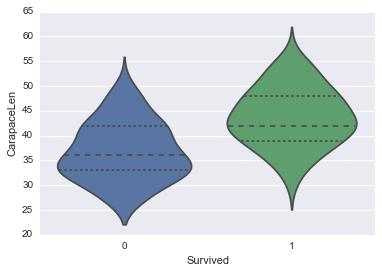

In [38]:
sns.violinplot (x="Survived", y="CarapaceLen",
                data=df_lobsters, inner="quart")

Although the classes are distinct in the aggregate, where the median carapace (outer shell) length is around 36 mm for the lobsters that died and 42 mm for those that survived, they are not cleanly separable.

## Notation

To develop some intuition and a classification algorithm, let's formulate the general problem and apply it to synthetic data sets.

Let the data consist of $m$ observations of $d$ continuously-valued predictors. In addition, for each data observation we observe a binary label whose value is either 0 or 1.

Just as in the linear regression case, represent each observation, or data point, by an _augumented_ vector, $\hat{x}_i^T$,

$$
\begin{array}{rcl}
  \hat{x}_i^T
    & \equiv &
      \left(\begin{array}{ccccc}
           1 &
        x_{i,1} &
        x_{i,2} &
         \vdots &
        x_{i,d}
      \end{array}\right)
      .
\end{array}
$$

That is, the point is the $d$ coordinates augmented by an initial dummy coordinate whose value is 1. This convention is similar to what we did in linear regression.

We can also stack these points as rows of a matrix, $X$, again, just as we did in regression:

$$
\begin{array}{rcl}
  X \equiv
    \left(\begin{array}{c}
      \hat{x}_0^T \\
      \hat{x}_1^T \\
      \vdots \\
      \hat{x}_{m-1}^T
    \end{array}\right)
  & = &
    \left(\begin{array}{ccccc}
      1 & x_{0,1} & x_{0,2} & \cdots & x_{0,d} \\
      1 & x_{1,1} & x_{1,2} & \cdots & x_{1,d} \\
        &         &         & \vdots & \\
      1 & x_{m-1,1} & x_{m-1,2} & \cdots & x_{m-1,d} \\
    \end{array}\right).
\end{array}
$$

We will take the labels to be a binary vector, $y^T \equiv \left(y_0, y_1, \ldots, y_{m-1}\right)^T$.

**Example: A synthetic training set.** We've pre-generated a synethetic data set consisting of labeled data points. Let's download and inspect it, first as a table and then visually.

In [39]:
df = pd.read_csv ('./logreg_points_train.csv')

display (df.head ())
print ("...")
display (df.tail ())

,x_1,x_2,label
0,-0.234443,-1.075960,1
1,0.730359,-0.918093,0
2,1.432270,-0.439449,0
3,0.026733,1.050300,0
4,1.879650,0.207743,0


...


,x_1,x_2,label
370,1.314300,0.746001,0
371,-0.759737,-0.042944,1
372,0.683560,-0.047791,0
373,0.774747,0.743837,0
374,0.899119,1.576390,0


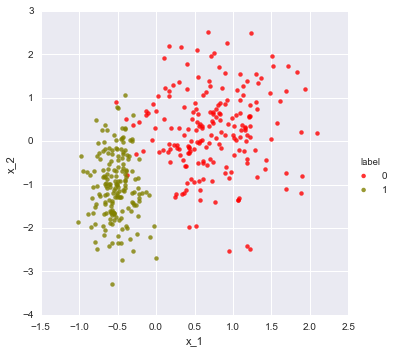

In [40]:
def make_scatter_plot (df, x="x_1", y="x_2", hue="label",
                       palette={0: "red", 1: "olive"},
                       size=5):
    sns.lmplot (x=x, y=y, hue=hue, data=df, palette=palette,
                fit_reg=False)
    
make_scatter_plot (df)

Next, let's extract the coordinates as a Numpy matrix of `points` and the labels as a Numpy column vector `labels`. Mathematically, the `points` matrix corresponds to $X$ and the `labels` vector corresponds to $y$.

In [41]:
points = np.insert (df.as_matrix (['x_1', 'x_2']), 0, 1.0, axis=1)
labels = df.as_matrix (['label'])

print ("First and last 5 points:\n", '='*23, '\n', points[:5], '\n...\n', points[-5:], '\n')
print ("First and last 5 labels:\n", '='*23, '\n', labels[:5], '\n...\n', labels[-5:], '\n')

First and last 5 points:
 [[ 1.        -0.234443  -1.07596  ]
 [ 1.         0.730359  -0.918093 ]
 [ 1.         1.43227   -0.439449 ]
 [ 1.         0.0267327  1.0503   ]
 [ 1.         1.87965    0.207743 ]] 
...
 [[ 1.         1.3143     0.746001 ]
 [ 1.        -0.759737  -0.0429435]
 [ 1.         0.68356   -0.0477909]
 [ 1.         0.774747   0.743837 ]
 [ 1.         0.899119   1.57639  ]] 

First and last 5 labels:
 [[1]
 [0]
 [0]
 [0]
 [0]] 
...
 [[0]
 [1]
 [0]
 [0]
 [0]] 



## Linear discriminants and the heaviside function

Suppose you think that the _boundary_ between the two clusters may be represented by a line. For the synthetic data example above, I hope you'll agree that such a model is not a terrible one.

A linear boundary is also known as a _linear discriminant_. Any point $x$ on this line may be described by $\theta^T x$, where $\theta$ is a vector of coefficients:

$$
\begin{array}{rcl}
  \theta
    & \equiv &
      \left(\begin{array}{c} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_d \end{array}\right)
      .
      \\
\end{array}
$$

For example, suppose our observations have two predictors each ($d=2$). Let the corresponding data point be $x^T \equiv (1.0, x_1, x_2)$. Then, $\theta^T \hat{x} = 0$ means that

$$
\begin{array}{rrcl}
  &
  \theta^T x = 0
  & = & \theta_0 + \theta_1 x_1 + \theta_2 x_2 \\
  \implies
  & x_2
    & = & -\frac{\theta_0}{\theta_2} - \frac{\theta_1}{\theta_2} x_1.
\end{array}
$$

So that describes points _on_ the line. However, given _any_ point $x$ in the $d$-dimensional space that is _not_ on the line, $\theta^T x$ still produces a value: that value will be positive on one side of the line ($\theta^T x > 0$) or negative on the other ($\theta^T x < 0$).

In other words, you can use the linear discriminant function, $\theta^T x$, to _generate_ a label: just reinterpret its sign!

One mathematical function that converts, say, a positive value to the label "1" and all other values to "0" is the _heaviside function_:

$$
\begin{array}{rcl}
  H(y) & \equiv & \left\{\begin{array}{ll}
      1 & \mathrm{if}\ y > 0
      \\
      0 & \mathrm{if}\ y \leq 0
    \end{array}\right..
\end{array}
$$

**Exercise 1** (2 points). Given the a $m \times (d+1)$ matrix of augmented points (i.e., the $X$ matrix) and a column vector $\theta$ of length $d+1$, implement a function to compute the value of the linear discriminant at each point. That is, the function should return a (column) vector $y$ where the $y_i = \theta^T x_i$.

In [42]:
def lin_discr (X, theta):
    return X.dot (theta)

In [43]:
import random
theta_test = [random.random () for _ in range (3)]
x1_test = [random.random () for _ in range (2)]
x2_test = [(-theta_test[0] - theta_test[1]*x1) / theta_test[2] for x1 in x1_test]
X_test = np.array ([[1.0, 1.0, 1.0, 1.0],
                    [x1*2 for x1 in x1_test] + [x1*0.5 for x1 in x1_test],
                    x2_test + x2_test]).T
LD_test = lin_discr (X_test, np.array ([theta_test]).T)
print (LD_test)
assert (LD_test[:2] > 0).all ()
assert (LD_test[2:] < 0).all ()
print ("\n(Passed.)")

[[ 0.19753947]
 [ 0.16914711]
 [-0.09876974]
 [-0.08457355]]

(Passed.)


**Exercise 2** (2 points). Implement the _heaviside function_, $H(y)$. Your function should allow for an arbitrary _matrix_ of input values and should apply the heaviside function to each element.

> There are several possible approaches that lead to one-line solutions. One uses only logical and arithmetic operators, which you will recall are implemented as elementwise operations for Numpy arrays. The other uses Numpy's [`sign()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.sign.html) function and transforms its output accordingly.

In [44]:
def heaviside (Y):
    return 1.0 * (Y > 0.0)

In [45]:
Y_test = np.array ([[-2.3, 1.2, 7.],
                    [0.0, -np.inf, np.inf]])
H_Y_test = heaviside (Y_test)

print ("Y:\n", Y_test)
print ("\nH(Y):\n", H_Y_test)

assert (H_Y_test.astype (int) == np.array ([[0, 1, 1], [0, 0, 1]])).all ()
print ("\n(Passed.)")

Y:
 [[-2.3  1.2  7. ]
 [ 0.  -inf  inf]]

H(Y):
 [[ 0.  1.  1.]
 [ 0.  0.  1.]]

(Passed.)


For the next exercise, we'll need the following functions.

In [46]:
def heaviside_int (Y):
    """Evaluates the heaviside function, but returns integer values."""
    return heaviside (Y).astype (dtype=int)

def gen_lin_discr_labels (points, theta, fun=heaviside_int):
    """
    Given a set of points and the coefficients of a linear
    discriminant, this function returns a set of labels for
    the points with respect to this discriminant.
    """
    score = lin_discr (points, theta)
    labels = fun (score)
    return labels

def plot_lin_discr (theta, df, x="x_1", y="x_2", hue="label",
                    palette={0: "red", 1: "olive"}, size=5,
                    linewidth=2):
    lm = sns.lmplot (x=x, y=y, hue=hue, data=df, palette=palette,
                     size=size, fit_reg=False)
    
    x_min, x_max = df[x].min (), df[x].max ()
    y_min, y_max = df[y].min (), df[y].max ()
    
    x2_min = (-theta[0][0] - theta[1][0]*x_min) / theta[2][0]
    x2_max = (-theta[0][0] - theta[1][0]*x_max) / theta[2][0]
    plt.plot ([x_min, x_max], [x2_min, x2_max], linewidth=linewidth)
    
    def expand_interval (x_limits, percent=10.0):
        x_min, x_max = x_limits[0], x_limits[1]
        if x_min < 0:
            x_min *= 1.0 + 1e-2*percent
        else:
            x_min *= 1.0 - 1e-2*percent
        if x_max > 0:
            x_max *= 1.0 + 1e-2*percent
        else:
            x_max *= 1.0 + 1e-2*percent
        return (x_min, x_max)
    x_view = expand_interval ((x_min, x_max))
    y_view = expand_interval ((y_min, y_max))
    lm.axes[0,0].set_xlim (x_view[0], x_view[1])
    lm.axes[0,0].set_ylim (y_view[0], y_view[1])
    
def mark_matches (a, b, exact=False):
    """
    Given two Numpy arrays of {0, 1} labels, returns a new boolean
    array indicating at which locations the input arrays have the
    same label (i.e., the corresponding entry is True).
    
    This function can consider "inexact" matches. That is, if `exact`
    is False, then the function will assume the {0, 1} labels may be
    regarded as the same up to a swapping of the labels. This feature
    allows
    
      a == [0, 0, 1, 1, 0, 1, 1]
      b == [1, 1, 0, 0, 1, 0, 0]
      
    to be regarded as equal. (That is, use `exact=False` when you
    only care about "relative" labeling.)
    """
    assert a.shape == b.shape
    a_int = a.astype (dtype=int)
    b_int = b.astype (dtype=int)
    all_axes = tuple (range (len (a.shape)))
    assert ((a_int == 0) | (a_int == 1)).all ()
    assert ((b_int == 0) | (b_int == 1)).all ()
    
    exact_matches = (a_int == b_int)
    if exact:
        return exact_matches

    assert exact == False
    num_exact_matches = np.sum (exact_matches)
    if (2*num_exact_matches) >= np.prod (a.shape):
        return exact_matches
    return exact_matches == False # Invert
    
def count_matches (a, b, exact=False):
    """
    Given two sets of {0, 1} labels, returns the number of mismatches.
    
    This function can consider "inexact" matches. That is, if `exact`
    is False, then the function will assume the {0, 1} labels may be
    regarded as similar up to a swapping of the labels. This feature
    allows
    
      a == [0, 0, 1, 1, 0, 1, 1]
      b == [1, 1, 0, 0, 1, 0, 0]
      
    to be regarded as equal. (That is, use `exact=False` when you
    only care about "relative" labeling.)
    """
    matches = mark_matches (a, b, exact=exact)
    return np.sum (matches)

**Exercise 3** (2 points). For the synthetic data you loaded above, determine a value of $\theta$ for which $H(\theta^T x)$ "best" separates the two clusters. Store this $\theta$ in a variable named `my_theta`, which should be a Numpy _column vector_. That is, define `my_theta` here using a line like:

```python
my_theta = np_col_vec ([0., -1., 3.])
```

where `np_col_vec` is defined below and the list of values are your best guesses at discriminating coefficients. The test code will check that your solution makes no more than ten misclassifications.

> Hint: We found a set of coefficients that commits just 5 errors for the 375 input points.

In [47]:
def np_col_vec (list_values):
    """Returns a Numpy column vector for the given list of scalar values."""
    return np.array ([list_values]).T

# Define `my_theta` as instructed above:
my_theta = np_col_vec ([-0.6, -3.5, -0.4]) # One of your solutions, which commits 6 errors

Detected 6 mismatches.


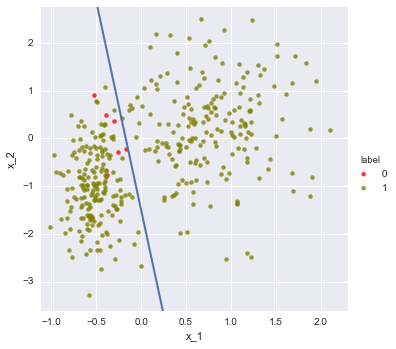

In [48]:
# Here are the labels generated by your discriminant:
my_labels = gen_lin_discr_labels (points, my_theta)

# Here is a visual check:
num_mismatches = len (labels) - count_matches (labels, my_labels)
print ("Detected", num_mismatches, "mismatches.")

df_matches = df.copy ()
df_matches['label'] = mark_matches (my_labels, labels).astype (dtype=int)
plot_lin_discr (my_theta, df_matches)

assert num_mismatches <= 10

## An alternative discriminant: the logistic or "sigmoid" function

The heaviside function, $H(\theta^T x)$, enforces a sharp boundary between classes around the $\theta^T x=0$ line. The following code produces a [contour plot](https://plot.ly/python/contour-plots/) to show this effect.

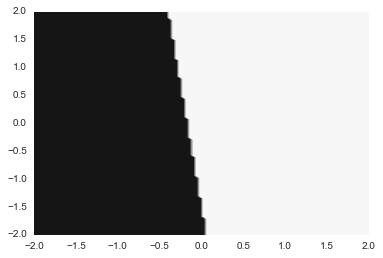

In [49]:
x1 = np.linspace (-2., +2., 100)
x2 = np.linspace (-2., +2., 100)
x1_grid, x2_grid = np.meshgrid (x1, x2)
h_grid = heaviside (my_theta[0] + my_theta[1]*x1_grid + my_theta[2]*x2_grid)
plt.contourf (x1, x2, h_grid)

However, as the lobsters example suggests, real data are not likely to be cleanly separable, especially when the number of features we have at our disposal is relatively small.

Since the labels are 0 or 1, you could look for a way to interpret labels as _probabilities_ rather than as hard (0 or 1) labels. The _logistic function_ provides a mathematical technique to do so:

$$
\begin{array}{rcl}
  G(y) & \equiv & \dfrac{1}{1 + e^{-y}}
\end{array}
$$

> This function is also sometimes called the _logit_ or _sigmoid_ function.

The logistic function takes any value in the range $(-\infty, +\infty)$ and produces a value in the range $(0, 1)$. Thus, given a value $x$, we can interpret it as a conditional probability that the label is 1 given $x$.

**Exercise 4** (2 points). Implement the logistic function. Inspect the resulting plot of $G(y)$ in 1-D and then the contour plot of $G(\theta^T{x})$. Your function should accept a Numpy matrix of values, `Y`, and apply the sigmoid elementwise.

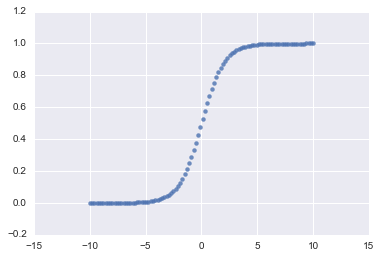

In [54]:
def logistic (Y):
    return 1.0 / (1.0 + np.exp (-Y))
    
# Plot your function for a 1-D input.
y_values = np.linspace (-10, 10, 100)
sns.regplot (y_values, logistic (y_values), fit_reg=False)


(Passed.)


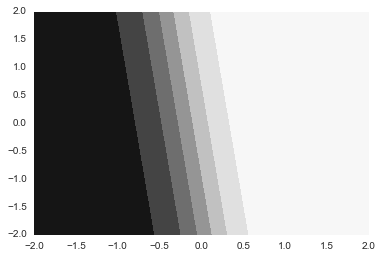

In [51]:
assert logistic (np.log (3)) == 0.75
assert logistic (-np.log (3)) == 0.25

g_grid = logistic (my_theta[0] + my_theta[1]*x1_grid + my_theta[2]*x2_grid)
plt.contourf (x1, x2, g_grid)
assert ((np.round (g_grid) - h_grid).astype (int) == 0).all ()

print ("\n(Passed.)")

**Exercise** (do not need to turn in). Consider a set of 1-D points generated by a _mixture of Gaussians_. That is, suppose that there are two Gaussian distributions over the 1-dimensional variable, $x \in (-\infty, +\infty)$, that have the _same_ variance ($\sigma^2$) but _different_ means ($\mu_0$ and $\mu_1$). Show that the conditional probability of observing a point labeled "1" given $x$ may be written as,

$$\mathrm{Pr}\left[l=1\,|\,x\right]
    \propto \dfrac{1}{1 + e^{-(\theta_0 + \theta_1 x)}},$$

for a suitable definition of $\theta_0$ and $\theta_1$.

_Hints._ Since the points come from Gaussian distributions,

$$
\begin{eqnarray}
  \mathrm{Pr}\left[x \, | \, l\right]
    & \equiv & \dfrac{1}{\sigma \sqrt{2 \pi}} \exp \left(-\frac{(x - \mu_l)^2}{2 \sigma^2}\right).
\end{eqnarray}
$$

To rewrite $\mathrm{Pr}\left[l\,|\,x\right]$ in terms of $\mathrm{Pr}\left[x \, | \, l\right]$, recall _Bayes's rule (also: Bayes's theorem)_:

$$
\begin{eqnarray}
  \mathrm{Pr}[l=1\,|\,x]
    & = &
      \dfrac{\mathrm{Pr}[x\,|\,l=1] \, \mathrm{Pr}[l=1]}
            {\mathrm{Pr}[x]},
\end{eqnarray}
$$

where the denominator can be expanded as

$$
\begin{eqnarray}
  \mathrm{Pr}[x] & = & \mathrm{Pr}[x\,|\,l=0] \, \mathrm{Pr}[l=0] + \mathrm{Pr}[x\,|\,l=1] \, \mathrm{Pr}[l=1].
\end{eqnarray}
$$

You may assume the prior probabilities of observing a 0 or 1 are given by $\mathrm{Pr}[l=0] \equiv p_0$ and $\mathrm{Pr}[l=1] \equiv p_1$.

**Generalizing to $d$-dimensions.** The preceding exercise can be generalized to $d$-dimensions. Let $\theta$ and $x$ be $(d+1)$-dimensional points. Then,

$$
\begin{eqnarray}
  \mathrm{Pr}\left[l=1\,|\,x\right]
    & \propto & \dfrac{1}{1 + \exp \left( -\theta^T x \right)}.
\end{eqnarray}
$$

**Exercise 5** (5 points). Verify the following properties of the logistic function, $G(y)$.

$$
\begin{array}{rcll}
  G(y)
    & = & \frac{e^y}{e^y + 1}
    & \mathrm{(P1)} \\
  G(-y)
    & = & 1 - G(y)
    & \mathrm{(P2)} \\
  \dfrac{dG}{dy}
    & = & G(y) G(-y)
    & \mathrm{(P3)} \\
  {\dfrac{d}{dy}} {\left[ \ln G(y) \right]}
    & = & G(-y)
    & \mathrm{(P4)} \\
  {\dfrac{d}{dy}} {\ln \left[ 1 - G(y) \right]}
    & = & -G(y)
    & \mathrm{(P5)}
\end{array}
$$

YOUR ANSWER HERE

## Determining the discriminant automatically via maximum likelihood estimation

Previously, you determined $\theta$ for our synthetic dataset experimentally. Can you compute a good $\theta$ automatically? One of the standard techniques in statistics is to perform a _maximum likelihood estimation_ (MLE) of a model's parameters, $\theta$. Indeed, you can use MLE to derive the normal equations for linear regression in a more "statistically principled" way.

**"Likelihood" as an objective function.** MLE derives from the following idea. Consider the joint probability of observing all of the labels, given the points and the parameters, $\theta$:

$$
  \mathrm{Pr}[y\,|\,X, \theta].
$$

Suppose these observations are independent and identically distributed (i.i.d.). Then the joint probability can be factored as the product of individual probabilities,

$$
\begin{eqnarray}
  \mathrm{Pr}[y\, | \,X, \theta] = \mathrm{Pr}[y_0, \ldots, y_{m-1} \,|\, \hat{x}_0, \ldots, \hat{x}_{m-1}, \theta]
  & = & \mathrm{Pr}[y_0 \,|\, \hat{x}_0, \theta] \cdots \mathrm{Pr}[y_{m-1} \,|\, \hat{x}_{m-1}, \theta] \\
  & = & \displaystyle \prod_{i=0}^{m-1} \mathrm{Pr}[y_i \,|\, \hat{x}_i, \theta].
\end{eqnarray}
$$

The _maximum likelihood principle_ says that you should try to choose $\theta$ to maximize the chances (or "likelihood") of seeing these particular observations. Thus, you can simply reinterpret the preceding probability as an objective function to optimize (in this case, to maximize).

For both mathematical and numerical reasons, we will use the _logarithm_ of the likelihood, or _log-likelihood_, as the objective function instead. Let's define it as

$$
\begin{eqnarray}
  \mathcal{L}(\theta; y, X)
    & \equiv &
      \log \left\{ \displaystyle \prod_{i=0}^{m-1} \mathrm{Pr}[y_i \,|\, \hat{x}_i, \theta] \right\} \\
    & = &
      \displaystyle \sum_{i=0}^{m-1} \log \mathrm{Pr}[y_i \,|\, \hat{x}_i, \theta].
\end{eqnarray}
$$

> We are using the symbol $\log$, which could be taken in any convenient base, such as the natural logarithm ($\ln y$) or the information theoretic base-two logarithm ($\log_2 y$).

The MLE fitting procedure then consists of two steps:

* For the problem at hand, decide on a model of $\mathrm{Pr}[y_i \,|\, \hat{x}_i, \theta]$.
* Run any optimization procedure to find the $\theta$ that maximizes $\mathcal{L}(\theta; y, X)$.

**Example: Logistic regression.** Let's say you have decided that the logistic function, $G(\hat{x}_i^T \theta) = G(\theta^T \hat{x}_i)$, is a good model of the probability of producing a label $y_i$ given the observation $\hat{x}_i^T$. Under the i.i.d. assumption, we can interpret the label $y_i$ as the result of flipping a coin, or a [Bernoulli trial](https://en.wikipedia.org/wiki/Bernoulli_trial), where the probability of success ($y_i=1$) is defined as $g_i = g_i(\theta) \equiv G(\hat{x}_i^T \theta)$. Thus,

$$
\begin{eqnarray}
  \mathrm{Pr}[y_i \,|\, \hat{x}_i, \theta]
    & \equiv & g_i^{y_i} \cdot \left(1 - g_i\right)^{1 - y_i}.
\end{eqnarray}
$$

The log-likelihood in turn becomes,

$$
\begin{eqnarray}
  \mathcal{L}(\theta; y, X)
    & = & \displaystyle
      \sum_{i=0}^{m-1} y_i \ln g_i + (1-y_i) \ln (1-g_i) \\
    & = & \displaystyle
      \sum_{i=0}^{m-1} y_i \ln \dfrac{g_i}{1-g_i} + \ln (1-g_i) \\
    & = & \displaystyle
      \sum_{i=0}^{m-1} y_i \theta^T \hat{x}_i + \ln (1-g_i).
\end{eqnarray}
$$

You can write the log-likelihood more compactly in a matrix-vector notation.

**Convention 1.** Let $u \equiv (1, \ldots, 1)^T$ be a column vector of all ones, with its length inferred from context. Let $A = \left(\begin{array}{cccc} a_0 & a_1 & \cdots & a_{n-1} \end{array}\right)$ be any matrix, where $\{a_i\}$ denote its $n$ columns. Then, the sum of the columns is

$$\sum_{i=0}^{n-1} a_i
  = \left(a_0\ a_1\ \cdots\ a_{n-1}\right)
      \cdot \left(\begin{array}{c}
              1 \\
              1 \\
              \vdots \\
              1
            \end{array}\right)
  = A u.
$$

**Convention 2.** Let $A = \left(a_{ij}\right)$ be any matrix and let $f(y)$ be any function that we have defined by default to accept a scalar argument $y$ and produce a scalar result. For instance, $f(y) = \ln y$ or $f(y) = G(y)$. Then, assume that $B = f(A)$ applies $f(\cdot)$ elementwise to $A$, returning a matrix $B$ whose elements $b_{ij} = f(a_{ij})$.

With these notational conventions, convince yourself that these are two different ways to write the log-likelihood for logistic regression.

$$
\begin{array}{rrcl}
  (\mathrm{V1}) & \mathcal{L}(\theta; y, X) & = & y^T \ln G(X \theta) + (u-y)^T \ln [u - G(X \theta)] \\
  (\mathrm{V2}) & \mathcal{L}(\theta; y, X) & = & y^T X \theta + u^T \ln G(-X \theta)
\end{array}
$$

**Exercise 6** (2 points). Implement the log-likelihood function in Python by defining a function with the following signature:

```python
  def log_likelihood (theta, y, X):
    ...
```

> To compute the elementwise logarithm of a matrix or vector, use Numpy's [`log`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log.html) function.

In [55]:
def log_likelihood (theta, y, X):
    z = X.dot (theta)
    u = np.ones ((len (y), 1))
    return y.T.dot (z) + u.T.dot (np.log (logistic (-z)))

In [56]:
npzfile_soln = np.load ('log_likelihood_soln.npz')
d_soln = npzfile_soln['arr_0']
m_soln = npzfile_soln['arr_1']
theta_soln = npzfile_soln['arr_2']
y_soln = npzfile_soln['arr_3']
X_soln = npzfile_soln['arr_4']
L_soln = npzfile_soln['arr_5']

L_you = log_likelihood (theta_soln, y_soln, X_soln)
your_err = np.max (np.abs (L_you/L_soln - 1.0))
display (Math (r'\left\|\dfrac{\mathcal{L}_{\tiny \mbox{yours}} - \mathcal{L}_{\tiny \mbox{solution}}}{\mathcal{L}_{\tiny \mbox{solution}}}\right\|_\infty \approx %g' % your_err))
assert your_err <= 1e-13

print ("\n(Passed.)")

<IPython.core.display.Math object>


(Passed.)


## Computing the MLE solution via gradient ascent: theory

To optimize the log-likelihood with respect to the parameters, $\theta$, you'd like to do the moral equivalent of taking its derivative, setting it to zero, and then solving for $\theta$.

For example, recall that in the case of linear regression via least squares minimization, carrying out this process produced an _analytic_ solution for the parameters, which was to solve the normal equations.

Unfortunately, for logistic regression---or for most log-likelihoods you are likely to ever write down---you _cannot_ usually derive an analytic solution. Therefore, you will need to resort to numerical optimization procedures.

**Gradient ascent, in 1-D.** The simplest procedure to maximize a function is _gradient ascent_ (or _steepest ascent_). If instead you are minimizing the function, then the equivalent procedure is gradient (or steepest) _descent_. Here is the basic idea in 1-D.

Suppose we wish to find the maximum of a scalar function $f(x)$ in one dimension, i.e., $x$ is also a scalar. At the maximum, $\dfrac{df(x)}{dx} = 0$.

Suppose instead that $\dfrac{df}{dx} \neq 0$ and consider the value of $f$ at a nearby point, $x + p$, as given approximately by a truncated Taylor series:

$$
\begin{eqnarray}
  f(x + p)
    & = &
      f(x) + p \dfrac{df(x)}{dx} + \mathcal{O}(p^2).
\end{eqnarray}
$$

To make progress toward maximizing $f(x)$, you'd like to choose $p$ so that $f(x+p) > f(x)$. One way is to choose $p=\alpha \cdot \mathrm{sign} \left(\dfrac{df}{dx}\right)$, where $0 < \alpha \ll 1$ is "small:"

$$
\begin{eqnarray}
  f \left(x + \alpha \cdot \mathrm{sign} \left(\dfrac{df}{dx}\right) \right)
    & \approx &
      f(x) + \alpha \left|\dfrac{df}{dx}\right| + \mathcal{O}(\alpha^2).
\end{eqnarray}
$$

If $\alpha$ is small enough, then you can neglect the $\mathcal{O}(\alpha^2)$ term and $f(x + p)$ will be larger than $f(x)$, thus making progress toward a maximum.

This scheme is the basic idea: starting from some initial guess $x$, refine the guess by taking a small step $p$ _in the direction_ of the derivative, i.e., $\mathrm{sign} \left(\dfrac{df}{dx}\right)$.

**Gradient ascent in higher dimensions.** Now suppose $x$ is a vector rather than a scalar. Then the value of $f$ at a nearby point $f(x + p)$, where $p$ is a vector, becomes

$$
\begin{eqnarray}
  f(x + p) = f(x) + p^T \nabla_x f(x) + \mathcal{O}(\|p\|^2),
\end{eqnarray}
$$

where $\nabla_x f(x)$ is the gradient of $f$ with respect to $x$. Just as in the 1-D case, you want a step $p$ such that $f(x + p) > f(x)$. To make as much progress as possible, let's choose $p$ to be parallel to $\nabla_x\,f(x)$, that is, proportional to the gradient. This intuition motivates the following choice of $p$:

$$
\begin{eqnarray}
  p \equiv \alpha \dfrac{\nabla_x\,f(x)}{\|\nabla_x\,f(x)\|}.
\end{eqnarray}
$$

Again, $\alpha$ is a kind of fudge factor. You need to choose it to be small enough that the high-order terms of the Taylor approximation become negligible, yet large enough that you can make reasonable progress.

**Gradient ascent applied to MLE.** Applying gradient ascent to the problem of maximizing the log-likelihood leads to the following algorithm.

* Start with some initial guess, $\theta(0)$.
* At each iteration $t \geq 0$ of the procedure, let $\theta(t)$ be the current guess.
* Compute the direction of steepest ascent by evaluating the gradient, $\Delta_t \equiv \nabla_{\theta(t)} \left\{\mathcal{L}(\theta(t); y, X)\right\}$.
* Take a step in the direction of the gradient, $\theta(t+1) \leftarrow \theta(t) + \alpha \dfrac{\Delta_t}{\|\Delta_t\|}$, where $\alpha$ is a suitably chosen fudge factor.
* Stop when the parameters don't change much or after some maximum number of steps.

This procedure should smell eerily like the one in [Lab 9](http://nbviewer.ipython.org/github/rvuduc/cse6040fa16labs/blob/master/lab9/part3.ipynb)! And as was true of Lab 9, the tricky bit is how to choose $\alpha$.

> One additional and slight distinction between this procedure and the Lab 9 procedure is that here we are optimizing using the _full_ dataset rather than processing data points one at a time. (That is, the step iteration variable $t$ used above is not used in exactly the same way as the step iteration $k$ was used in Lab 9.)
>
> Another question is, how do we know this procedure will converge to the global maximum, rather than, say, a local maximum? For that you need a deeper analysis of a specific $\mathcal{L}(\theta; y, X)$, to show, for instance, that it is convex in $\theta$.

## Implementing logistic regression using MLE by gradient ascent

Let's apply the gradient ascent procedure to the logistic regression problem, in order to determine a good $\theta$.

**Exercise 7** (3 points). Show the following.

$$
\begin{eqnarray}
  \nabla_\theta \left\{\mathcal{L}(\theta; y, X)\right\}
    & = & X^T \left[ y - G(X \cdot \theta)\right].
\end{eqnarray}
$$

YOUR ANSWER HERE

**Exercise 8** (2 points). Implement a function to compute the gradient of the log-likelihood. Your function should have the signature,

```python
  def grad_log_likelihood (theta, y, X):
      ...
```

In [59]:
def grad_log_likelihood(theta, y, X):
    return X.T.dot(y - logistic(X.dot(theta)))

In [60]:
npzfile_grad_soln = np.load ('grad_log_likelihood_soln.npz')
d_grad_soln = npzfile_grad_soln['arr_0']
m_grad_soln = npzfile_grad_soln['arr_1']
theta_grad_soln = npzfile_grad_soln['arr_2']
y_grad_soln = npzfile_grad_soln['arr_3']
X_grad_soln = npzfile_grad_soln['arr_4']
L_grad_soln = npzfile_grad_soln['arr_5']

L_grad_you = grad_log_likelihood (theta_grad_soln, y_grad_soln, X_grad_soln)
your_grad_err = np.max (np.abs (L_grad_you/L_grad_soln - 1.0))
display (Math (r'\left\|\dfrac{\nabla\, \mathcal{L}_{\tiny \mbox{yours}} - \nabla\,\mathcal{L}_{\tiny \mbox{solution}}}{\nabla\, \mathcal{L}_{\tiny \mbox{solution}}}\right\|_\infty \approx %g' % your_grad_err))
assert your_grad_err <= 1e-13

print ("\n(Passed.)")

<IPython.core.display.Math object>


(Passed.)


**Exercise 9** (4 points). Implement the gradient ascent procedure to determine $\theta$, and try it out on the sample data.

In the code skeleton below, we've set up a loop to run a fixed number, `MAX_STEP`, of gradient ascent steps. Also, when normalizing the step $\Delta_t$, use the two-norm.

> In your solution, we'd like you to store *all* guesses in the matrix `thetas`, so that you can later see how the $\theta(t)$ values evolve. To extract a particular column `t`, use the notation, `theta[:, t:t+1]`. This notation is necessary to preserve the "shape" of the column as a column vector.

Your (hand) solution: [-0.6 -3.5 -0.4]
Computed solution: [ -3.53802259 -14.10328545  -2.83146094]

=== Comparisons ===


<IPython.core.display.Math object>

Your manual (hand-picked) solution is [ 1.5] , vs. MLE (via gradient ascent), which is [ 1.24953961]


<IPython.core.display.Math object>

Your manual (hand-picked) solution is [ 8.75] , vs. MLE (via gradient ascent), which is [ 4.98092178]

=== The MLE solution, visualized ===


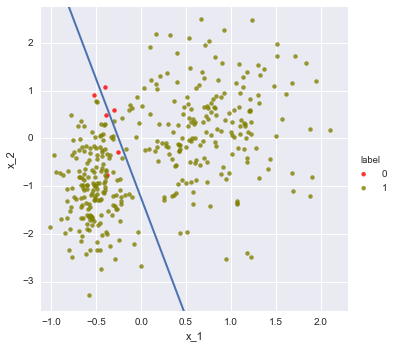

In [65]:
MAX_STEP = 50
ALPHA = 0.5

# Get the data coordinate matrix, X, and labels vector, y
X = points
y = labels.astype (dtype=float)

# Store *all* guesses, for subsequent analysis
thetas = np.zeros ((3, MAX_STEP+1))

for t in range (MAX_STEP):
    theta_t = thetas[:, t:t+1]
    delta_t = grad_log_likelihood(theta_t,y,X)
    delta_t /= np.linalg.norm(delta_t)
    delta_t *= ALPHA
    thetas[:,t+1:t+2] = theta_t + delta_t
    
theta_ga = thetas[:, MAX_STEP:]
print ("Your (hand) solution:", my_theta.T.flatten ())
print ("Computed solution:", theta_ga.T.flatten ())

print ("\n=== Comparisons ===")
display (Math (r'\dfrac{\theta_0}{\theta_2}:'))
print ("Your manual (hand-picked) solution is", my_theta[0]/my_theta[2], \
      ", vs. MLE (via gradient ascent), which is", theta_ga[0]/theta_ga[2])
display (Math (r'\dfrac{\theta_1}{\theta_2}:'))
print ("Your manual (hand-picked) solution is", my_theta[1]/my_theta[2], \
      ", vs. MLE (via gradient ascent), which is", theta_ga[1]/theta_ga[2])

print ("\n=== The MLE solution, visualized ===")
ga_labels = gen_lin_discr_labels (points, theta_ga)
df_ga = df.copy ()
df_ga['label'] = mark_matches (ga_labels, labels).astype (dtype=int)
plot_lin_discr (theta_ga, df_ga)

In [66]:
print ("\n=== Mismatch counts ===")

my_labels = gen_lin_discr_labels (points, my_theta)
my_mismatches = len (labels) - count_matches (labels, my_labels)
print ("Your manual (hand-picked) solution has", num_mismatches, "mismatches.")

ga_labels = gen_lin_discr_labels (points, theta_ga)
ga_mismatches = len (labels) - count_matches (labels, ga_labels)
print ("The MLE method produces", ga_mismatches, "mismatches.")

assert ga_mismatches <= 8
print ("\n(Passed.)")


=== Mismatch counts ===
Your manual (hand-picked) solution has 6 mismatches.
The MLE method produces 6 mismatches.

(Passed.)


**The gradient ascent trajectory.** Let's take a look at how gradient ascent progresses. (You might try changing the $\alpha$ parameter and see how it affects the results.)

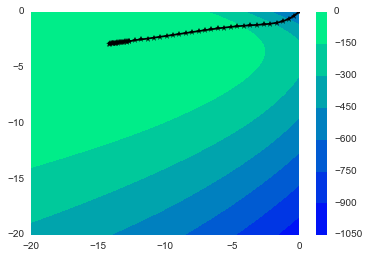

In [68]:
n1_ll = 100
x1 = np.linspace (-20., 0., n1_ll)

n2_ll = 100
x2 = np.linspace (-20., 0., n2_ll)
x1_grid, x2_grid = np.meshgrid (x1, x2)

ll_grid = np.zeros ((n1_ll, n2_ll))
for i1 in range (n1_ll):
    for i2 in range (n2_ll):
        theta_i1_i2 = np.array ([[thetas[0, MAX_STEP]],
                                 [x1_grid[i1][i2]],
                                 [x2_grid[i1][i2]]])
        ll_grid[i1][i2] = log_likelihood (theta_i1_i2, y, X)

p = plt.contourf (x1, x2, ll_grid, cmap=plt.cm.get_cmap("winter"))
plt.colorbar ()
plt.plot (thetas[1, :], thetas[2, :], 'k*-')

## Numerical optimization via Newton's method

The fudge factor, $\alpha$, in gradient ascent should give you pause. Can you choose the step size or direction in a better or more principled way?

One idea is [_Newton's method_](http://www.math.uiuc.edu/documenta/vol-ismp/13_deuflhard-peter.pdf), summarized below.

**The basic idea, in 1-D.** Suppose you start at a point $x$ and, assuming you are not yet at the optimum, you wish to take a step $x + p$ so that $f(x + p)$ is the maximum.

However, instead of trying to maximize $f(x + p)$ directly, let's replace $f(x + p)$ with some approximation $q(p)$, and then choose a $p$ to maximize $q(p)$. A simple choice for $q(p)$ is a _quadratic_ function in $p$. This choice is motivated by two factors: (a) since it's quadratic, it should have some sort of extreme point (and hopefully an actual maximum), and (b) it is a higher-order approximation than a linear one, and so hopefully more accurate than a linear one as well.

$$
\begin{array}{rcl}
  f(x + p)
    & \approx & f(x) + p \dfrac{df}{dx} + \frac{1}{2} p^2 \dfrac{d^2 f}{dx^2}
    & \equiv  & q(p).
\end{array}
$$

To maximize $q(p)$, take its derivative and then solve for the $p_*$ such that $q(p_*) = 0$:

$$
\begin{array}{rcl}
  \left.\dfrac{dq}{dp}\right|_{p=p_*}
    & = & \dfrac{df}{dx} + p_* \dfrac{d^2 f}{dx^2} = 0 \\
  \implies p_*
    & = & -\dfrac{df}{dx} \left(\dfrac{d^2 f}{dx^2}\right)^{-1}.
\end{array}
$$

That is, the optimal step $p_*$ is the negative of the first derivative of $f$ divided by its second derivative.

**Generalizing to higher dimensions.** To see how this procedure works in higher dimensions, you will need not only the gradient of $f(x)$, but also its _Hessian_, which is the moral equivalent of a second derivative.

_Definition:_ **the Hessian.** Let $f(v)$ be a function that takes a _vector_ $v$ of length $n$ as input and returns a scalar. The _Hessian_ of $f(v)$ is an $n \times n$ matrix, $H_v(f)$, whose entries are all $n^2$ possible second derivatives with respect to the components of $v$. That is, the $(i, j)$ element of $H_v(f)$ is given by $h_{ij}$ such that

$$
\begin{eqnarray}
  h_{ij}
    & \equiv & \dfrac{\partial^2}{\partial v_i \partial v_j} f(v).
\end{eqnarray}
$$

Armed with a Hessian, the Newton step is defined as follows, by direct analogy to the 1-D case. First, the Taylor series approximation of $f(x + p)$ for multidimensional variables is, as it happens,

$$
\begin{array}{rcl}
  f(x + p)
    & \approx & f(x) + {p^T \, \nabla_x \, f} + {\frac{1}{2}\,p^T H_x(f) \, p}
    & \equiv  & q(p).
\end{array}
$$

As in the 1-D case, we want to find an extreme point of $q(p)$. Taking its "derivative" (gradient), $\nabla_p q$, and setting it to 0 yields,

$$
\begin{array}{rcl}
  \nabla_p \, q(p)
    & = & \nabla_x \, f(x) + H_x(f) \, p = 0 \\
  \implies
  H_x(f) \cdot p
    & = & -\, \nabla_x \, f(x).
\end{array}
$$

In other words, to choose the next step $p$, Newton's method suggests you must solve a system of linear equations, where the matrix is the Hessian of $f$ and the right-hand side is the negative gradient of $f$.

**Summary: Newton's method.** Summarizing the main ideas from above, Newton's method to maximize the scalar objective function $f(x)$ where $x$ is a vector, consists of the following steps:

* Start with some initial guess $x(0)$.
* At step $t$, compute the _search direction_ $p(t)$ by solving $H_{x(t)}(f) \cdot p(t) = -\, \nabla_x \, f(x(t))$.
* Compute a new (and hopefully improved) guess by the update, $x(t+1) \leftarrow x(t) + p(t)$.

## Implementing logistic regression via a Newton-based MLE

To perform MLE for the logistic regression model using Newton's method, you need both the gradient of the log-likelihood as well as the Hessian. You already know how to compute the gradient from the preceding exercises; so what about the Hessian?

Notationally, that calculation will be a little bit easier to write down and program with the following definition.

_Definition:_ **Elementwise product**. Let $A \equiv (a_{ij})$ and $B \equiv (b_{ij})$ be $m \times n$ matrices. Denote the _elementwise product_ of $A$ and $B$ by $A \odot B$. That is, if $C = A \odot B$, then element $c_{ij} = a_{ij} \cdot b_{ij}$.

If $A$ is $m \times n$ but $B$ is instead just $m \times 1$, then we will "auto-extend" $B$. Put differently, if $B$ has the same number of rows as $A$ but only 1 column, then we will take $C = A \odot B$ to have elements $c_{ij} = a_{ij} \cdot b_{i}$.

In Python, you can use [`np.multiply()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.multiply.html) for elementwise multiplication of Numpy arrays.

In [ ]:
A = np.array ([[1, 2, 3],
               [4, 5, 6]])
B = np.array ([[-1, 2, -3],
               [4, -5, 6]])

print (np.multiply (A, B)) # elementwise product
print ()
print (np.multiply (A, B[:, 0:1])) # "auto-extend" version

**(Optional) Exercise** (do not need to turn anything in). Show that the Hessian of the log-likelihood for logistic regression is

$$
\begin{array}{rcl}
  H_{\theta} \left( \mathcal{L}(\theta; l, X) \right)
    & = & -\left( X \odot G(X \theta) \right)^T \left( X \odot G(-X \theta) \right).
\end{array}
$$

**Exercise 10** (2 points). Implement a function to compute the Hessian of the log-likelihood. The signature of your function should be,

```python
  def hess_log_likelihood (theta, y, X):
      ...
```

In [75]:
def hess_log_likelihood(theta, y,X):
    z = X.dot(theta)
    A = np.multiply(X, logistic(z))
    B = np.multiply(X, logistic (-z))
    return -A.T.dot(B)

In [76]:
npzfile_hess_soln = np.load ('hess_log_likelihood_soln.npz')
d_hess_soln = npzfile_hess_soln['arr_0']
m_hess_soln = npzfile_hess_soln['arr_1']
theta_hess_soln = npzfile_hess_soln['arr_2']
y_hess_soln = npzfile_hess_soln['arr_3']
X_hess_soln = npzfile_hess_soln['arr_4']
L_hess_soln = npzfile_hess_soln['arr_5']

L_hess_you = hess_log_likelihood (theta_hess_soln, y_hess_soln, X_hess_soln)
your_hess_err = np.max (np.abs (L_hess_you/L_hess_soln - 1.0))
display (Math (r'\left\|\dfrac{H_{\tiny \mbox{yours}} - H_{\tiny \mbox{solution}}}{H_{\tiny \mbox{solution}}}\right\|_\infty \approx %g' % your_hess_err))
assert your_hess_err <= 1e-13

print ("\n(Passed.)")

<IPython.core.display.Math object>


(Passed.)


**Exercise 11** (4 points). Finish the implementation of a Newton-based MLE procedure for the logistic regression problem.

Your (hand) solution: [-0.6 -3.5 -0.4]
Computed solution: [ -3.76500606 -15.63082207  -3.04255951]

=== Comparisons ===


<IPython.core.display.Math object>

Your manual (hand-picked) solution is [ 1.5] , vs. MLE (via Newton's method), which is [ 1.23744698]


<IPython.core.display.Math object>

Your manual (hand-picked) solution is [ 8.75] , vs. MLE (via Newton's method), which is [ 5.1373924]

=== The MLE solution, visualized ===


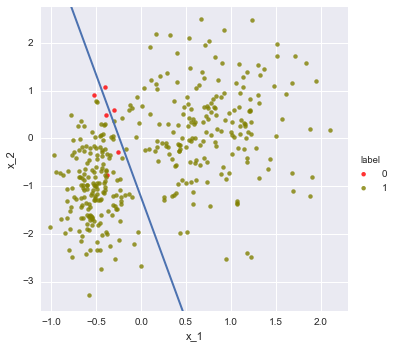

In [80]:
MAX_STEP = 10

# Get the data coordinate matrix, X, and labels vector, l
X = points
y = labels.astype (dtype=float)

# Store *all* guesses, for subsequent analysis
thetas_newt = np.zeros ((3, MAX_STEP+1))

for t in range (MAX_STEP):
    # YOUR CODE HERE
    theta_t = thetas_newt[:,t:t+1]
    H_t = hess_log_likelihood(theta_t,y,X)
    g_t = -grad_log_likelihood (theta_t,y,X)
    p_t = np.linalg.solve(H_t,g_t)
    thetas_newt[:,t+1:t+2] = theta_t + p_t 

theta_newt = thetas_newt[:, MAX_STEP:]
print ("Your (hand) solution:", my_theta.T.flatten ())
print ("Computed solution:", theta_newt.T.flatten ())

print ("\n=== Comparisons ===")
display (Math (r'\dfrac{\theta_0}{\theta_2}:'))
print ("Your manual (hand-picked) solution is", my_theta[0]/my_theta[2], \
      ", vs. MLE (via Newton's method), which is", theta_newt[0]/theta_newt[2])
display (Math (r'\dfrac{\theta_1}{\theta_2}:'))
print ("Your manual (hand-picked) solution is", my_theta[1]/my_theta[2], \
      ", vs. MLE (via Newton's method), which is", theta_newt[1]/theta_newt[2])

print ("\n=== The MLE solution, visualized ===")
newt_labels = gen_lin_discr_labels (points, theta_newt)
df_newt = df.copy ()
df_newt['label'] = mark_matches (newt_labels, labels).astype (dtype=int)
plot_lin_discr (theta_newt, df_newt)

In [81]:
print ("\n=== Mismatch counts ===")

my_labels = gen_lin_discr_labels (points, my_theta)
my_mismatches = len (labels) - count_matches (labels, my_labels)
print ("Your manual (hand-picked) solution has", num_mismatches, "mismatches.")

newt_labels = gen_lin_discr_labels (points, theta_newt)
newt_mismatches = len (labels) - count_matches (labels, newt_labels)
print ("The MLE+Newton method produces", newt_mismatches, "mismatches.")

assert newt_mismatches <= ga_mismatches
print ("\n(Passed.)")


=== Mismatch counts ===
Your manual (hand-picked) solution has 6 mismatches.
The MLE+Newton method produces 6 mismatches.

(Passed.)


**Exercise 12** (1 point). The following cell creates a contour plot of the log-likelihood, as done previously in this notebook. Add code to display the trajectory taken by Newton's method.

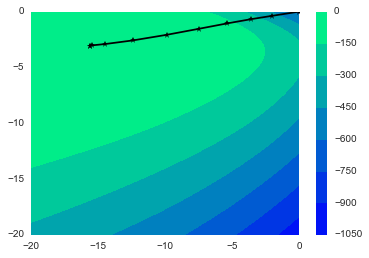

In [83]:
p = plt.contourf (x1, x2, ll_grid, cmap=plt.cm.get_cmap("winter"))
plt.colorbar ()

plt.plot(thetas_newt[1, :],thetas_newt[2,:], 'k*-')